In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import sys
import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicDualBand

from qubic.lib.MapMaking.Qmaps import InputMaps
from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import *

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)

(0.0, 0.0002)

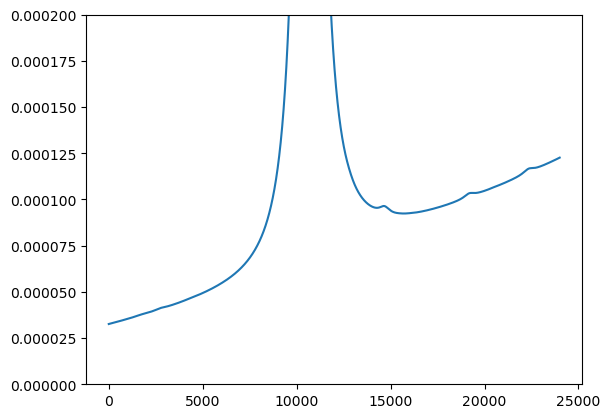

In [4]:
# Import the atm absorption spectrum
abs_spectrum = atm.absorption_spectrum()

plt.plot(abs_spectrum)
plt.ylim(0, 0.0002)

In [5]:
# Import the atm temperature maps
atm_maps = atm.get_temp_maps(atm.rho_map)
print(atm_maps.shape)

# Import the atm integrated absorption spectrum
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

(12, 300, 300)


Text(0, 0.5, 'Integrated absorption spectrum')

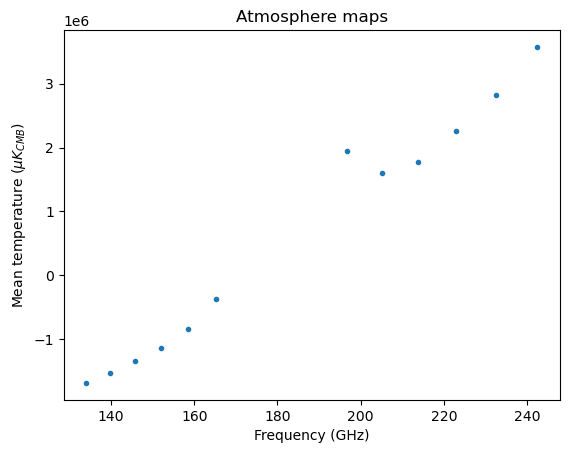

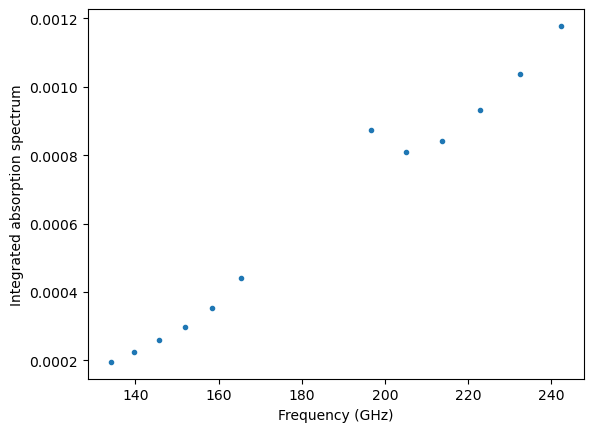

In [6]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i, :]))
plt.figure()
plt.plot(frequencies, mean_atm_maps, '.')
plt.title('Atmosphere maps')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.figure()
plt.plot(frequencies, integrated_abs_spectrum, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Integrated absorption spectrum')

Text(0.5, 1.0, 'Atmosphere temperature map at 134.06 GHz')

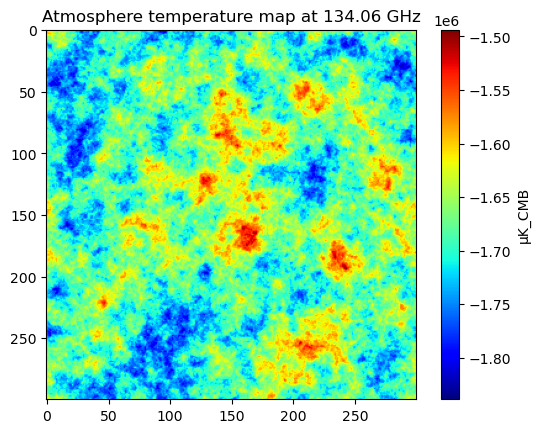

In [7]:
plt.imshow(atm_maps[0], cmap='jet')
plt.colorbar(label='µK_CMB')
plt.title('Atmosphere temperature map at {:.2f} GHz'.format(frequencies[0]))

316.44761928968586 -58.75808063333319
(12, 196608, 3)


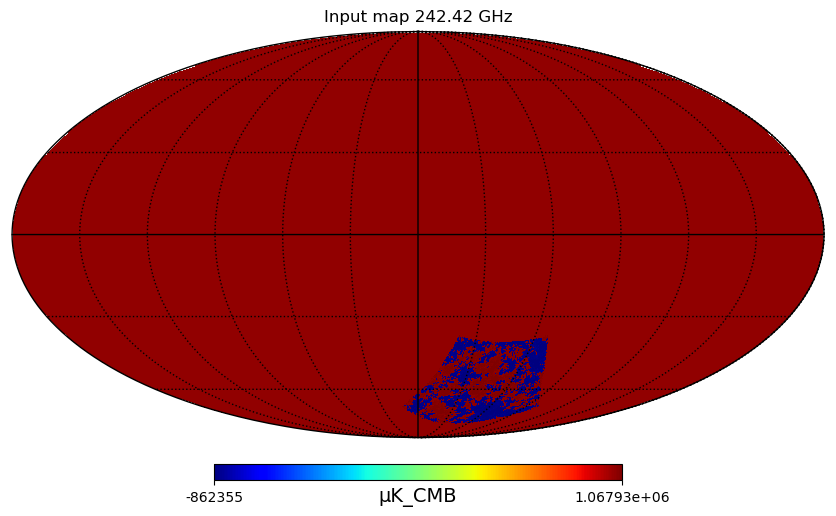

In [8]:
# Build input maps : CMB + Atmsophere (only for I map)
input_maps = np.zeros((len(frequencies), hp.nside2npix(params['nside']), 3))
input_maps[:, :, 0] += atm.get_healpy_atm_maps_2d(atm_maps)
print(input_maps.shape)

for irec in range(input_maps.shape[0]):
    index = np.where(input_maps[irec, :, 0] != 0)
    input_maps[irec, index, 0] -= np.mean(input_maps[irec, index, 0])

hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist', title='Input map {:.2f} GHz'.format(frequencies[-1]))
hp.graticule()

(2, 196608, 3)
[149.23728273 218.881348  ]


(130.0, 250.0)

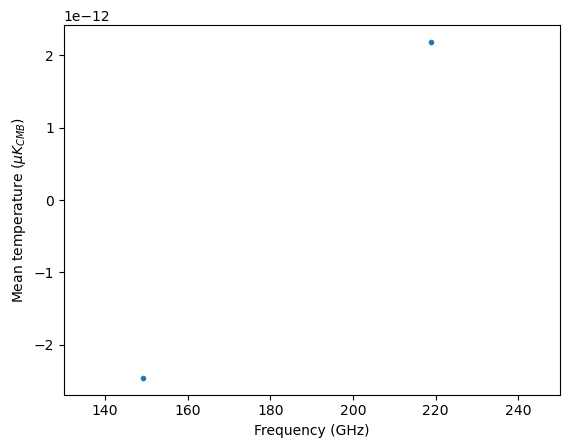

In [9]:
# Compute the Nrec maps from the Nsub maps
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape) 
print(true_frequencies)   
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.xlabel('Frequency (GHz)')
plt.xlim(130, 250)

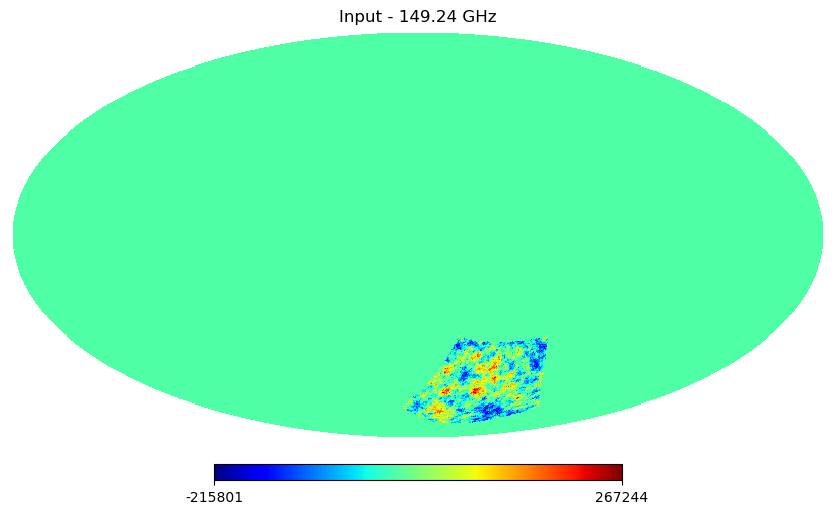

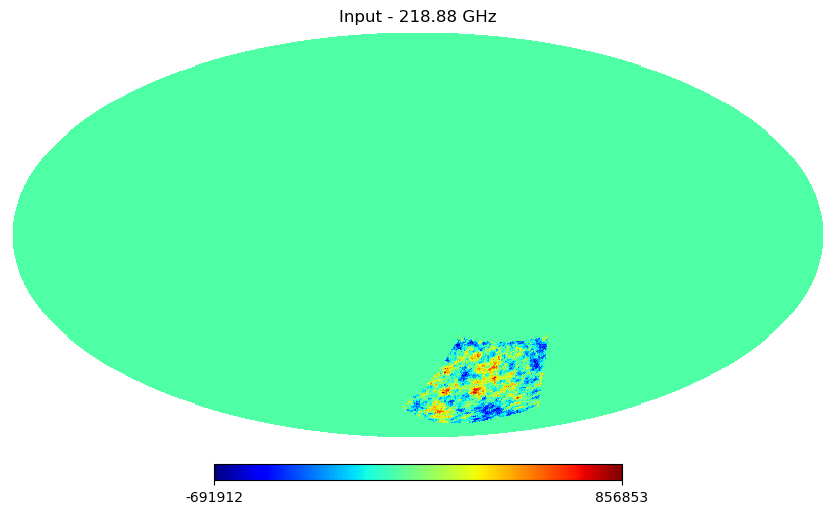

In [10]:
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0], cmap='jet', title='Input - {:.2f} GHz'.format(true_frequencies[inu]))

# Map-making

In [11]:
# Build the QUBIC operators
H_tod_qubic = QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
Qacq = QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
if params['nrec']==2:
    H_rec_qubic = Qacq.get_operator().operands[0]
else:
    H_rec_qubic = Qacq.get_operator()
invN_qubic = Qacq.get_invntt_operator()
tod_qubic = H_tod_qubic(input_maps).ravel()

You asked 1 pointings with repeat strategy so I will provide 0 pointings repeated 3 times.


ValueError: failed in converting 3rd argument `matrix' of _flib.polarization.matrix_rot3d_i4_r4 to C/Fortran array

In [ ]:
coverage = Qacq.coverage

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

In [ ]:
print('H_rec', H_rec_qubic.shapein, H_rec_qubic.shapeout)
print('invN', invN_qubic.shapein, invN_qubic.shapeout)
print('H_tod', H_tod_qubic.shapein, H_tod_qubic.shapeout)

H_rec (2, 992, 999) (1982016,)
invN (1984, 999) (1984, 999)
H_tod (12, 196608, 3) (1984, 999)


In [ ]:
H_tod = H_tod_qubic
R = ReshapeOperator(H_rec_qubic.shapeout, invN_qubic.shapein)

H_rec = R(H_rec_qubic)
invN = invN_qubic
tod = tod_qubic

In [ ]:
print('H_rec_qubic', H_rec_qubic.shapein, H_rec_qubic.shapeout)
print("H_rec", H_rec.shapein, H_rec.shapeout)
print("invN", invN.shapein, invN.shapeout)
print('invN qubic', invN_qubic.shapein, invN_qubic.shapeout)
print("TOD", tod.shape)

H_rec_qubic (2, 992, 999) (1982016,)
H_rec (2, 992, 999) (1984, 999)
invN (1984, 999) (1984, 999)
invN qubic (1984, 999) (1984, 999)
TOD (1982016,)


In [ ]:
# Build PCG
R = ReshapeOperator(tod.shape, invN_qubic.shapein)
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * R(tod)
x0 = true_maps*0

In [ ]:
stacked_dptdp_inv = np.zeros((len(H_rec.operands)*len(H_rec.operands[0].operands),12*params['nside']**2))
for i in range(len(H_rec.operands)):
    for j in range(len(H_rec.operands[0].operands)):
        H_single = H_rec.operands[i].operands[j].operands[0]
        D = H_single.operands[1]
        P = H_single.operands[-1]
        sh = P.matrix.data.index.shape
        no_det = 992
        point_per_det = int(sh[0] / no_det)
        mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
        sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
        for det, (start, end) in enumerate(sample_ranges):
            indices = P.matrix.data.index[start:end, :]  
            weights = P.matrix.data.r11[start:end, :]
            flat_indices = indices.ravel()
            flat_weights = weights.ravel()

            mapPitPi = np.zeros(12 * params['nside']**2)
            np.add.at(mapPitPi, flat_indices, flat_weights**2)

            mapPtP_perdet_seq[det, :] = mapPitPi
        D_elements = D.data
        D_sq = D_elements**2
        mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
        dptdp = mapPtP_seq_scaled.sum(axis = 0)
        dptdp_inv = 1 / dptdp
        dptdp_inv[np.isinf(dptdp_inv)] = 0.
        stacked_dptdp_inv[int(i*len(H_rec.operands)+ j)] = dptdp_inv
M = BlockDiagonalOperator( \
                    [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
                    new_axisin=0)
        

AttributeError: 'ReshapeOperator' object has no attribute 'operands'

In [ ]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

3
 Iter     Tol      time
   1: 5.7483e-01 0.65654 [4.44997409e+04 3.45103200e-13 3.16013926e-13 7.48471379e+04
 3.67933645e-13 3.35191213e-13 1.11980546e+05 5.20804531e-12
 4.82909175e-12 1.58912655e+05 4.67333095e-12 4.26723824e-12]
3
   2: 1.9173e-01 0.65182 [3.84410083e+04 6.57520218e-13 5.98540193e-13 6.79713796e+04
 7.00327802e-13 6.34595218e-13 8.18754077e+04 7.36328217e-12
 6.67036054e-12 1.17662275e+05 6.54764096e-12 5.86128642e-12]
3
   3: 1.3676e-01 0.66454 [3.22626971e+04 9.70328773e-13 8.77786787e-13 6.06334533e+04
 1.03189750e-12 9.29960197e-13 7.08815549e+04 7.62154107e-12
 7.02268835e-12 9.96715357e+04 6.69859938e-12 6.13647478e-12]
3
   4: 7.9493e-02 0.67962 [2.72081061e+04 1.24053181e-12 1.11963327e-12 5.40697142e+04
 1.31687882e-12 1.18520132e-12 6.51900418e+04 7.97154957e-12
 7.16662182e-12 8.79521284e+04 6.95071372e-12 6.23667995e-12]
3
   5: 4.7106e-02 0.63709 [2.30041547e+04 1.50401456e-12 1.35786826e-12 4.74923982e+04
 1.59263921e-12 1.43603468e-12 5.82234284e+0

Text(0, 0.5, 'Convergence')

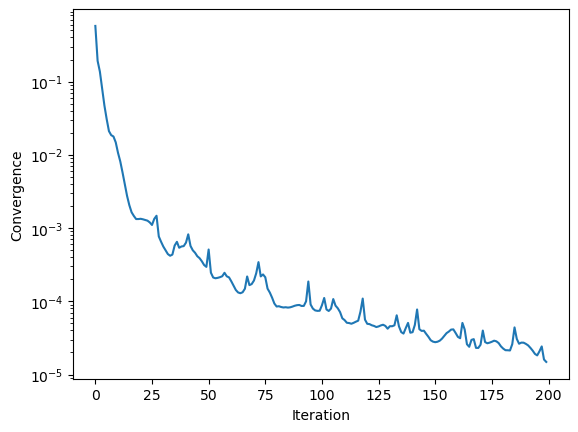

In [ ]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

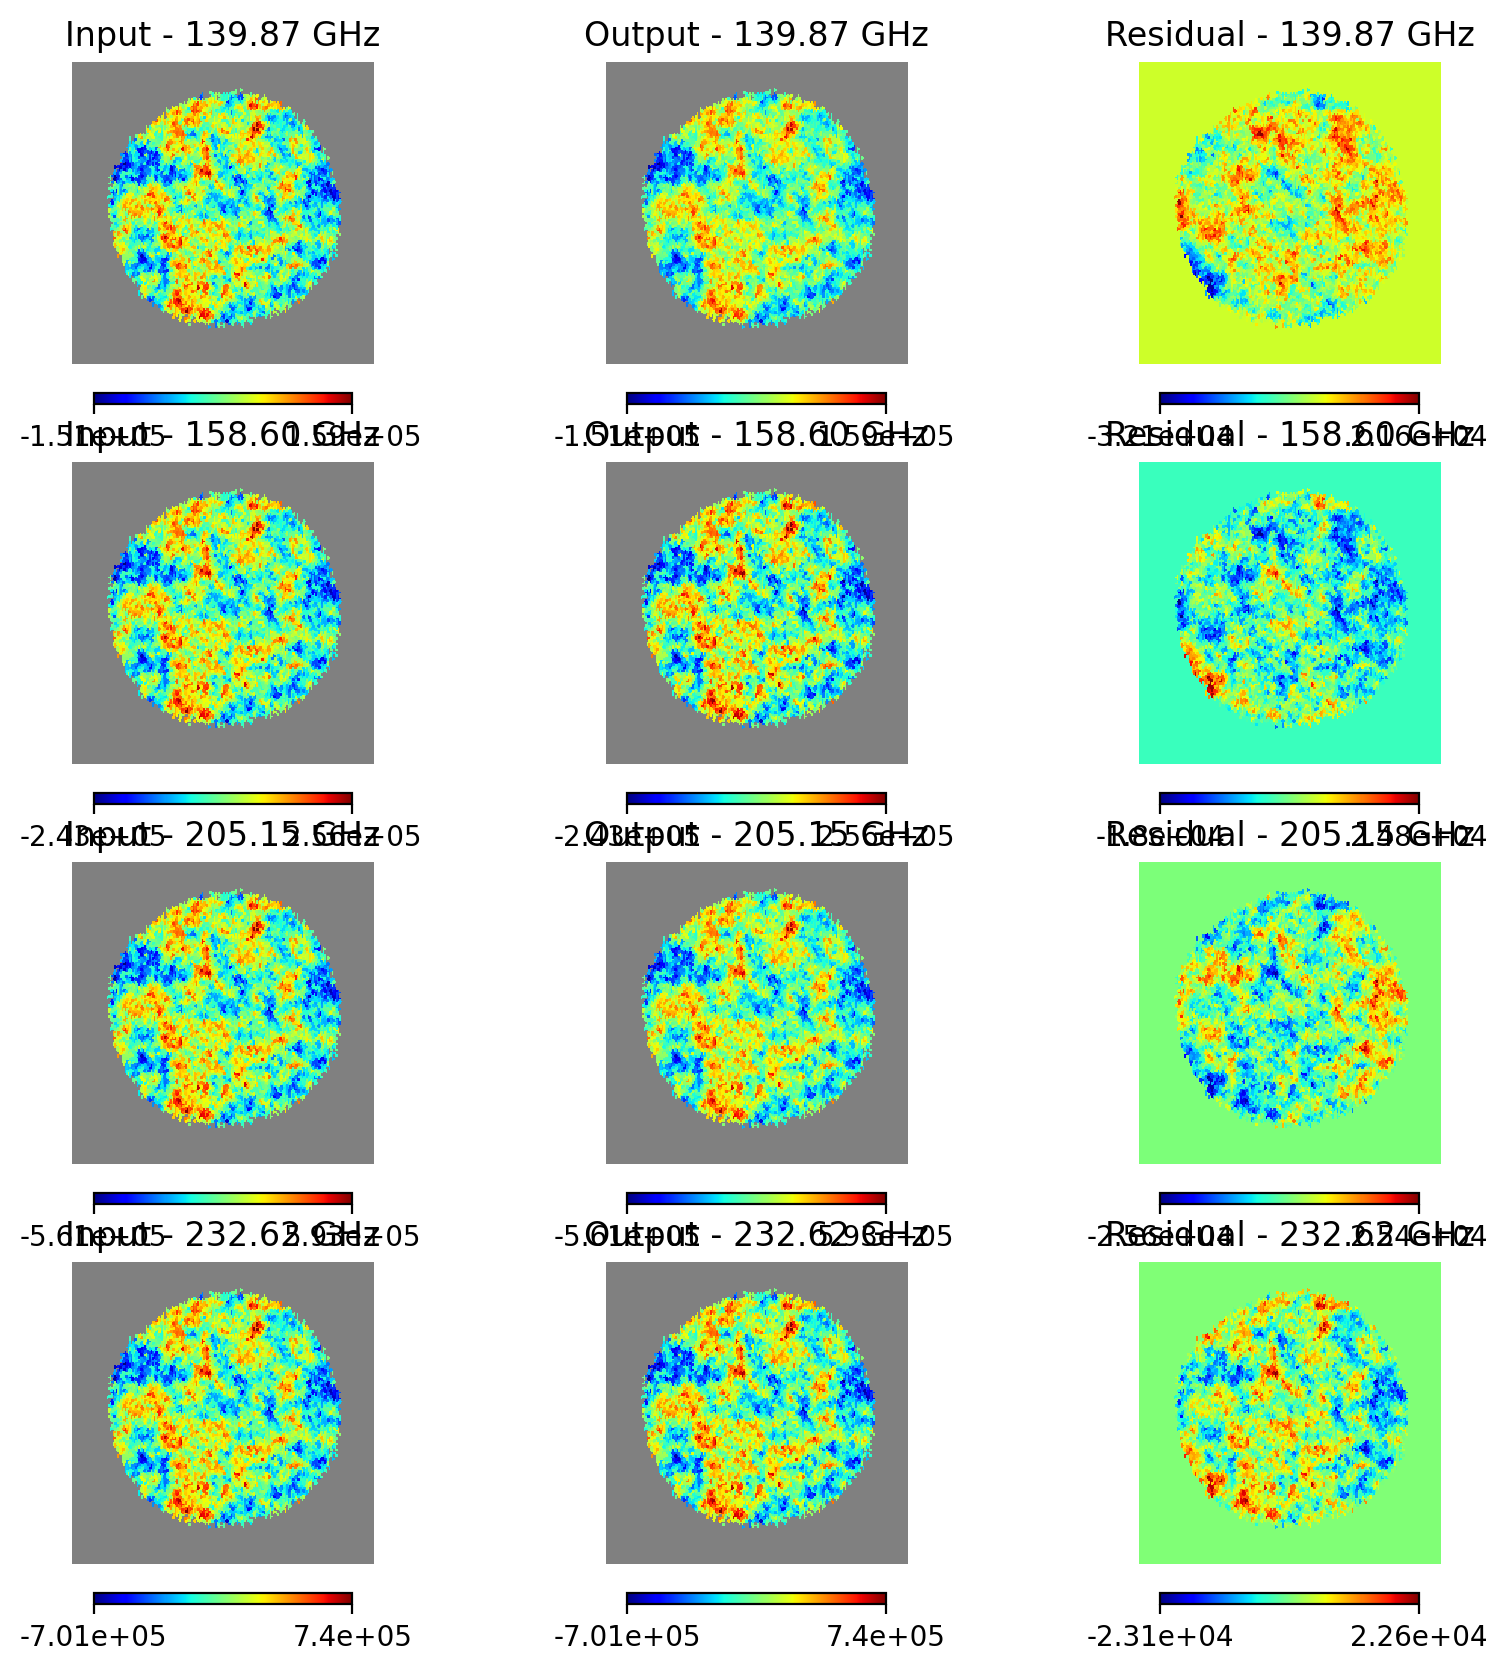

In [ ]:

plt.figure(figsize=(8, 8), dpi=200)
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3
reso = 15

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

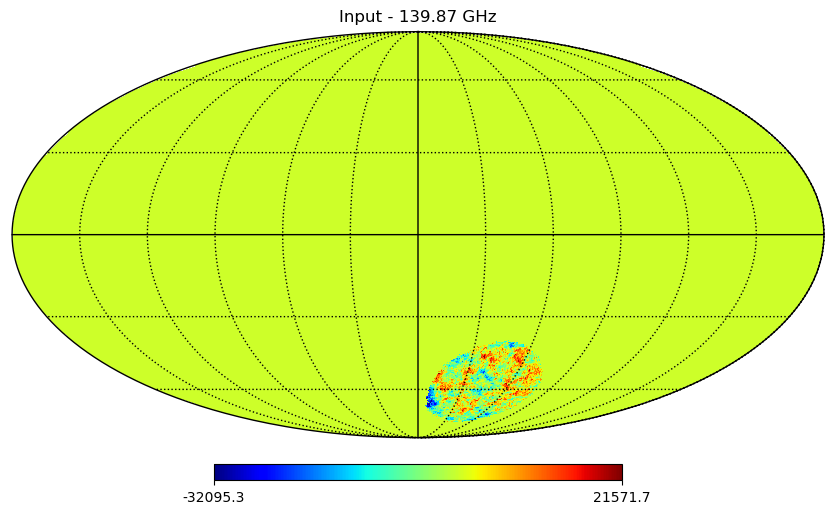

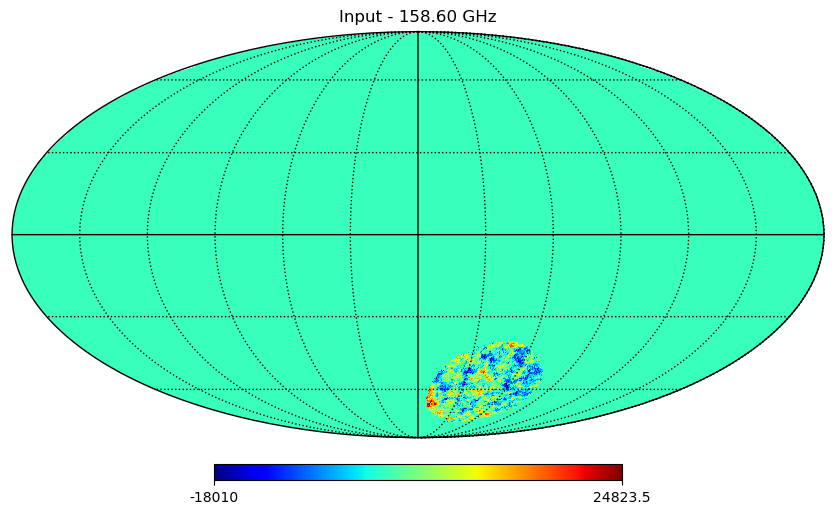

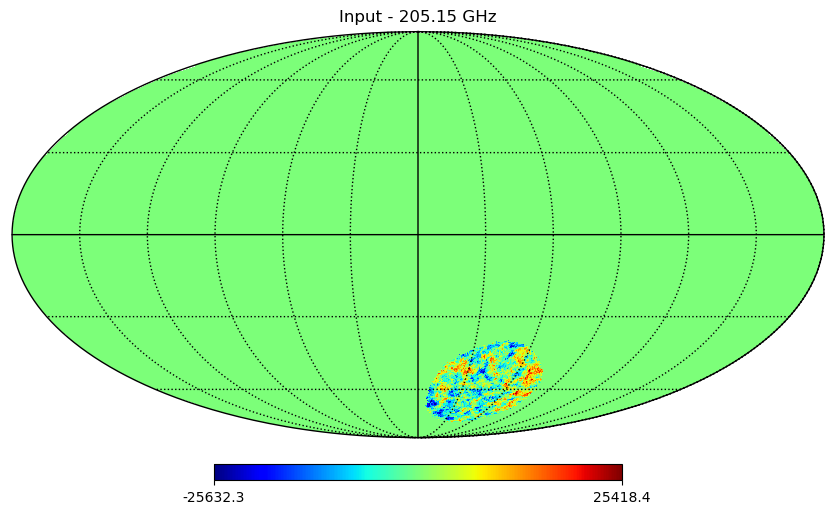

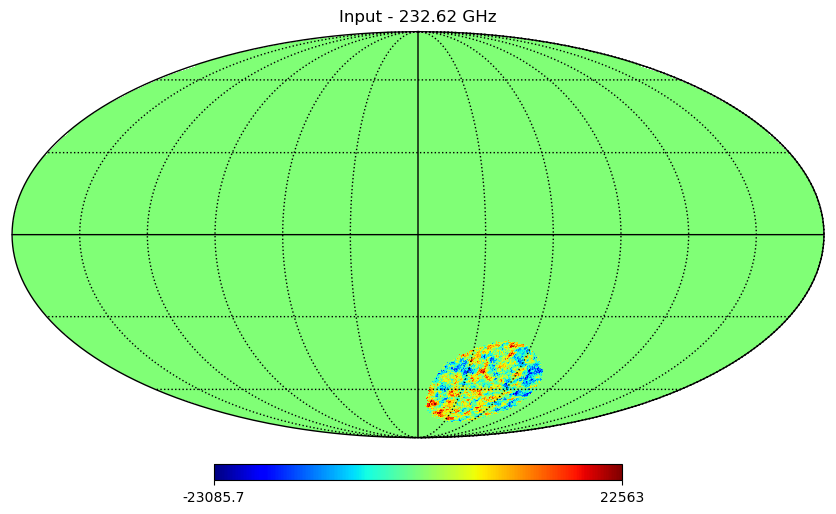

In [ ]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet',title='Input - {:.2f} GHz'.format(true_frequencies[inu]))
    hp.graticule()

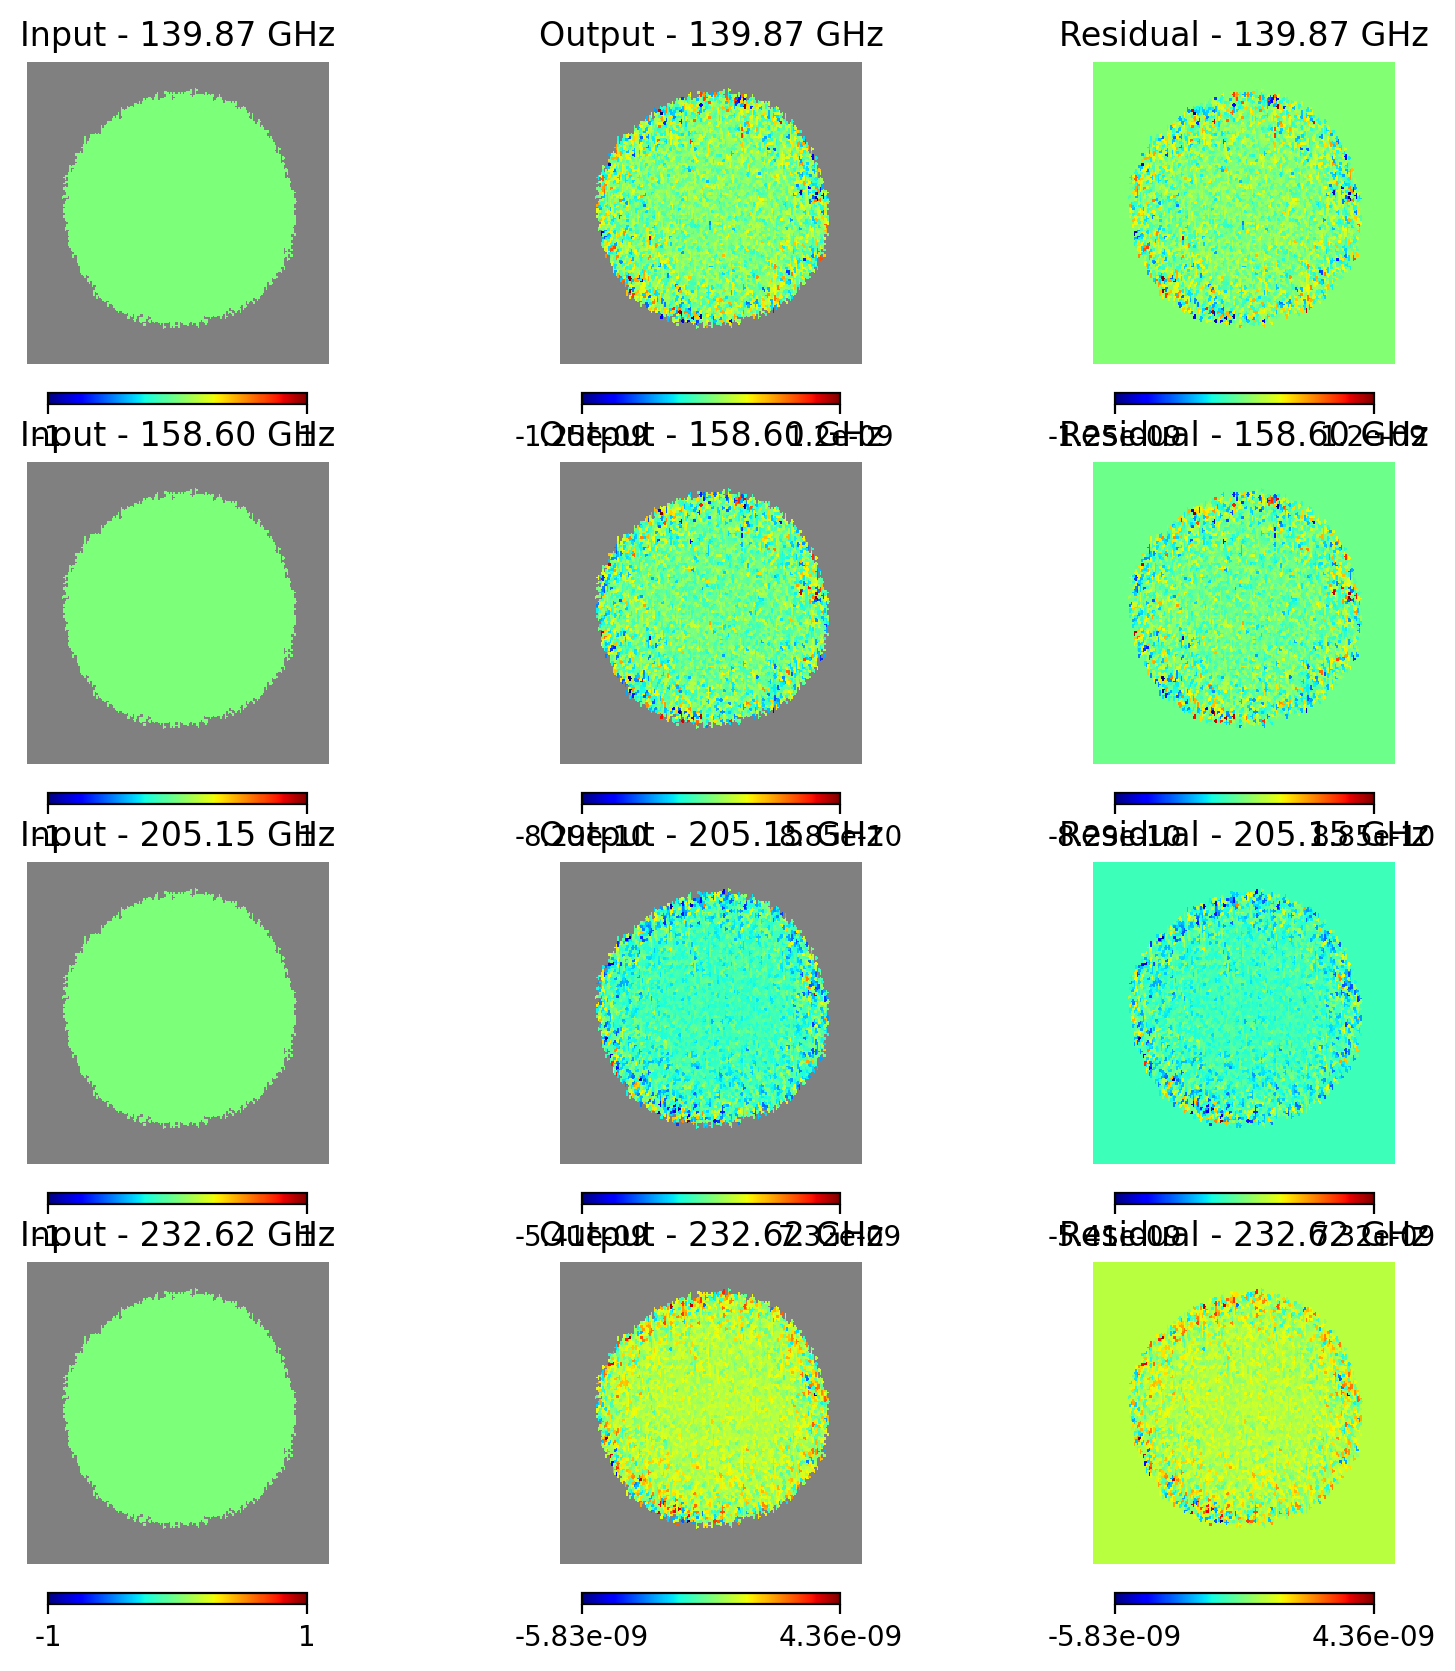

In [ ]:
plt.figure(figsize=(8, 8), dpi=200)

k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 2

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

In [ ]:
stop

NameError: name 'stop' is not defined